### Markowitz Optimization

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import risk_models, expected_returns, EfficientFrontier

TICKERS = ['AAPL','GOOGL','XOM','WMT','V','NVDA','JPM','F']
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS, 
    start = START_DATE, 
    end = END_DATE,
    progress = False,
    interval = '1d'
)['Close']

#### Convex Portfolio Optimization

무위험 이자율을 초과하는 수익률이 기대값 $\mu$와 기대 공분산 $V$를 갖는 $N$개의 보유 자산 포트폴리오를 고려해 보자. Markowitz의 시도는 고전적인 자산 배분 문제를 이차 계획법으로 공식화하는 것이었다.

$$\min_{\omega} \frac{1}{2}\omega^\prime V \omega \text{  subject to } : \omega^\prime a = 1$$

여기서 $a$는 포트폴리오의 제약식을 특정짓는다. 이 문제는 다음과 같은 라그랑지안 형태로 표현할 수 있다.

$$\mathcal{L}\left[\omega, \lambda\right] = \frac{1}{2} \omega^\prime V \omega - \lambda \left( \omega ^ \prime a - 1\right)$$

1계 조건은 다음과 같다.

$$\frac{\partial \mathcal{L}\left[ \omega, \lambda\right]}{\partial \omega} = V \omega - \lambda a$$
$$\frac{\partial \mathcal{L} \left[ \omega, \lambda\right]}{\partial \lambda} = \omega^\prime a - 1$$

1계 조건을 0으로 놓으면 다음을 얻는다.

$$
\begin{align}
V \omega - \lambda a = 0 &\Rightarrow \omega = \lambda V^{-1}a \\
\omega ^ \prime a = a^\prime \omega = 1 &\Rightarrow \lambda a ^\prime V^{-1}a = 1 \Rightarrow \lambda = \frac{1}{a^\prime V^{-1} a}
\end{align}
$$

따라서

$$\omega ^* = \frac{V^{-1}a}{a^\prime V^{-1} a}$$

2계 조건은 이 해가 라그랑지의 최소점이라는 것을 확인한다.

$$
\begin{vmatrix} 
\frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \omega^2} 
& \frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \omega \partial \lambda}
\\ \frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \lambda \partial \omega}
& \frac{\partial \mathcal{L}^2(\omega, \lambda)}{\partial \lambda^2} 
\end{vmatrix} = \begin{vmatrix}
V^\prime & -a^\prime \\
a & 0
\end{vmatrix} = a^\prime a \geq 0
$$

이제 특성 벡터 $a$의 공식을 살펴보자.

In [2]:
mu = expected_returns.mean_historical_return(data)
S = risk_models.sample_cov(data)

In [5]:
ef = EfficientFrontier(mu, S)

In [6]:
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

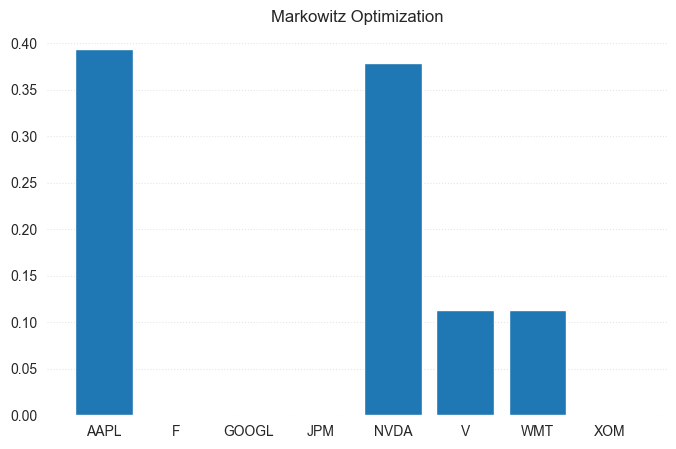

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))
plt.bar(
    cleaned_weights.keys(),
    cleaned_weights.values()
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.title('Markowitz Optimization')
plt.show()

#### Markowitz’s Curse

공분산, 상관관계 행렬의 조건수는 최대와 최저 고유값 사이의 비율의 절대값이다. 아래의 그림은 몇 개 상관계수 행렬의 정렬된 고유값을 보여주고 있는데, 조건 수가 각 선의 처음 값과 마지막 값 사이의 비율이다. 이 값은 대각 상관계수 행렬에 대해 최저이며, 그 자체의 역수다. 상관관계를 갖는 상품을 추가할수록 조건 수는 커진다. 어떤 점에서 조건 수는 너무 높아져 수치 오차가 역행렬을 매우 불안정하게 만든다. 어떤 원소의 사소한 변화도 완전히 다른 역행렬을 만들어 버린다. 이것이 바로 마코위츠의 저주이다. 투자 상품들이 더 많이 상관되어 있을수록 분산의 필요성은 더 커지지만, 이때 더욱 불안정한 해법을 얻게 될 가능성이 커진다. 분산의 혜택은 종종 추정 오차에 의해 더 많이 상쇄된다. 

대각 상관계수 행렬은 가장 낮은 조건 수를 가진다. 상관된 상품을 추가할수록 최대 고유값은 더 커지고, 최저 고유값은 더 낮아진다. 조건 수는 빠르게 증가하고 불안정한 역상관계수 행렬을 형성한다. 어떤 점을 넘어서면 분산의 혜택은 추정 오차로 인해 더 많이 상쇄된다.

공분산의 행렬의 크기를 증가시키면 문제가 더욱 악화될 뿐이다. 각각의 공분산 계수가 더 적은 자유도로 추정되기 때문이다. 일반적으로 특이 행렬이 아닌 크기 $N$의 공분산 행렬을 계산하려면 적어도 $\frac{N(N+1)}{2}$의 독립적이고 동일하게 분포된 관측값이 필요하다. 예를 들어, 크기 50의 공분산 행렬의 역행렬을 구하려면 적어도 5년치의 일별 IID 데이터가 필요하다. 대부분의 투자자들이 알다시피 상관관계 구조가 이런 긴 기간 동안에는 어떠한 합리적 신뢰 수준에서도 변하지 않는 경우는 없다. 이런 문제의 심각함은 단순한 동일가중 포트폴리오가 평균 분산과 리스크 기반의 최적화보다 샘플 외 성과가 더 좋다는 사실로 잘 요약할 수 있다.

#### From Geometric to Hierarchical Relationships

이런 불안정 문제는 Kolm(2014)의 논문에 적혀 있는 것처럼 최근 주목을 받기 시작했다. 대부분의 대안들은 베이지안 사전 확률이나(Black and Litterman, 1992) 공분산 행렬의 역행렬의 수치적 안정성을 개선하는(Ledoit and Wolf, 2003) 등의 추가 제약을 포함함으로써 안정성을 얻으려 시도했다(Clarke, 2002).

지금까지 논의한 모든 방법들은 최근에 발표됐지만, 수학의 고전적인 영역으로부터 도출됐는데 그 예로는 기하학, 선형 대수, 미분학을 들 수 있다. 상관계수 행렬은 수익률 계열에 의해 형성된 벡터 공간상 두 벡터 각도의 코사인을 측정하는 선형 대수 객체다. 이차 최적화 알고리즘이 불안정한 원인 중 하나는 벡터 공간이 완전 그래프로 모델되었기 때문인데, 모든 노드는 잠재적으로 다른 노드를 대체할 수 있는 후보가 된다. 알고리즘 관점에서 역행렬을 구하는 것은 완전 그래프상의 부분 상관계수를 계산하는 것을 의미한다. 아래의 그림은 $20 \times 20$ 공분산 행렬로 의미하는 관계를 시각화해 주며, 20개의 노드와 190개의 에지로 표현된다. 이런 복잡한 구조는 작은 예측 오차를 확대시켜 불완전한 해를 유도한다. 직관적으로 불필요한 에지는 제거하는 것이 바람직하다.

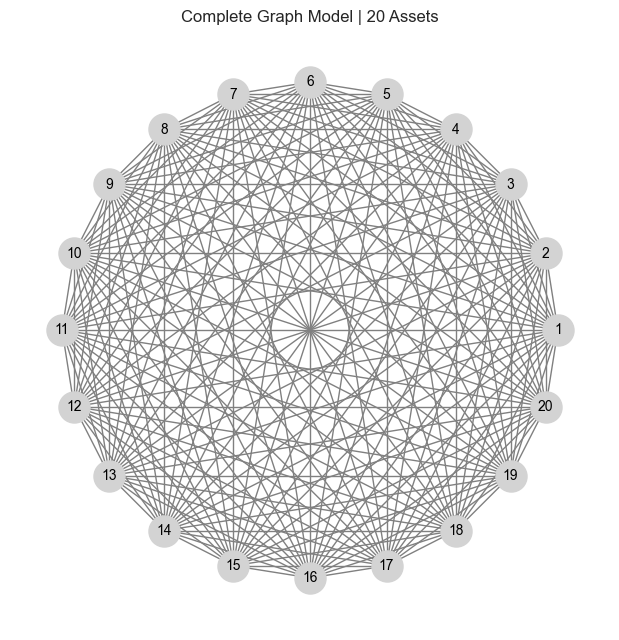

In [25]:
import networkx as nx
num_assets = 20
G = nx.complete_graph(num_assets)
labels = {i: f"{i+1}" for i in range(num_assets)}

plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G) 
nx.draw(
    G, pos, 
    with_labels=True, 
    labels=labels, 
    node_size=500, 
    node_color='lightgray', 
    font_size=10, 
    edge_color='gray'
)
plt.title("Complete Graph Model | 20 Assets")
plt.show()